# Bayesian Gradient Descent
Implementation of the BGD algorithm:
The basic assumption is that in each step, the previous posterior distribution is used as the new prior distribution and that the parametric distribution is approximately a Diagonal Gaussian, that is, all the parameters of the weight vector $\theta$ are independent.

We define the following:
* $\epsilon_i$ - a Random Variable (RV) sampled from $N(0,1)$
* $\theta$ - the weights which we wish to find their posterior distribution
* $\phi = (\mu,\sigma)$ - the parameters which serve as a condition for the distribution of $\theta$
* $\mu$ - the mean of the weights' distribution, initially sampled from $N(0,\frac{2}{n_{input} + n_{output}})$
* $\sigma$ - the STD (Variance's root) of the weights' distribution, initially set to a small constant.
* $K$ - the number of sub-networks
* $\eta$ - hyper-parameter to compenstate for the accumulated error (tunable).
* $L(\theta)$ - Loss function

Algorithm Sketch:

* Initialize: $\mu, \sigma, \eta, K$
* For each sub-network k: sample $\epsilon_0^k$ and set $\theta_0^k = \mu_0 + \epsilon_0^k \sigma_0$
* Repeat:

    1. For each sub-network k: sample $\epsilon_i^k$, compute gradients: $\frac{\partial L(\theta)}{\partial \theta_i}$
    2. Set $\mu_i \leftarrow \mu_i - \eta\sigma_i^2\mathbb{E}_{\epsilon}[\frac{\partial L(\theta)}{\partial \theta_i}] $
    3. Set $\sigma_i \leftarrow \sigma_i\sqrt{1 + (\frac{1}{2} \sigma_i\mathbb{E}_{\epsilon}[\frac{\partial L(\theta)}{\partial \theta_i}\epsilon_i])^2} - \frac{1}{2}\sigma_i^2\mathbb{E}_{\epsilon}[\frac{\partial L(\theta)}{\partial \theta_i}\epsilon_i] $
    4. Set $\theta_i^k = \mu_i + \epsilon_i^k \sigma_i$ for each k (sub-network)
    
* Until convergence criterion is met
* Note: i is the $i^{th}$ component of the vector, that is, if we have n paramaters (weights, bias) for each sub-network, then for each parameter we have $\mu_i$ and $\sigma_i$

The expectactions are estimated using Monte Carlo method:

$\mathbb{E}_{\epsilon}[\frac{\partial L(\theta)}{\partial \theta_i}] \approx \frac{1}{K}\sum_{k=1}^{K}\frac{\partial L(\theta^{(k)})}{\partial \theta_i} $


$\mathbb{E}_{\epsilon}[\frac{\partial L(\theta)}{\partial \theta_i}\epsilon_i] \approx \frac{1}{K}\sum_{k=1}^{K}\frac{\partial L(\theta^{(k)})}{\partial \theta_i}\epsilon_i^{(k)} $

### Loss Function $L(\theta)$ Derivation for Regression Problems

$L(\theta) = -log(P(D|\theta)) = -log(\prod_{i=1}^{M} P(D_i|\theta)) = -\sum_{i=1}^{M} log(P(D_i|\theta))$

Recall that from our Gaussian noise assumption, we dervied that the target (label) $t$ is also Gaussian distributed, such that: $$ P(t|x,\theta) = N(t|y(x,\theta), \beta^{-1}) $$
where $\beta$ is the percision (the inverse variance).
Assuming that the dataset is IID, we get the following:
$$ P(t|x,\theta, \beta) = \prod_{i=1}^{M} P(t_i|x_i,\theta, \beta) $$
Taking the negative logarithm, we get:
$$ -log( P(t|x,\theta, \beta)) = \frac{\beta}{2}\sum_{i=1}^M [y(x_i,\theta) - t_i]^2 -\frac{N}{2}ln(\beta) + \frac{N}{2}ln(2\pi) $$
Maximizing the log-likelihood is equivalent to minimizing the sum: $$ \frac{1}{2}\sum_{i=1}^M [y(x_i,\theta) - t_i]^2 $$ with respect to $\theta$ (looks similar to MSE, without the normalization), which is why we use `reduce_sum` in the code and not `reduce_mean`.

Note: we denote D as a general expression for the data, and in our case is the probability of the target conditiond on the input and the weights. Pay attention that $L(\theta)$ is the log of the probability which is log of an expression between [0,1], thus, the loss itself is not bounded. The probability is a Gaussian (which is of course, bounded).

We wish to test the algorithm by learning $y = x^3$ with samples from $y = x^3 +\zeta$ such that $\zeta$~$N(0,9)$ where the loss function is SSE and eventually compare its performance to the BP algorithm which we observed in Stage One. We'll take 20 training examples and perform 40 epochs.

### Network Prameters:
* Sub-Networks (K) = 10
* Hidden Layers (per Sub-Network): 1
* Neurons per Layer: 100
* Loss: SSE (Sum of Square Error)
* Optimizer: BGD (weights are updated using BGD, unbiased Monte-Carlo gradients)



In [6]:
# imports
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from bgd_model import BgdModel
from matplotlib import pyplot as plt
from datetime import datetime
import time
from random import shuffle
import os
import json
from collections import OrderedDict
%matplotlib inline

# Training

In [2]:
def set_train_flags(num_sub_networks=10, hidden_units=100, num_layers=1, eta=1.0, sigma_0=0.0001,
                   batch_size=5, epochs=40, n_inputs=1, n_outputs=1, decay_steps=10000, decay_rate=1/10,
                   display_step=100, save_freq=200):
    
    tf.app.flags.FLAGS.__flags.clear()

    # Network parameters
    tf.app.flags.DEFINE_integer('num_sub_networks', num_sub_networks, 'Number of hidden units in each layer')
    tf.app.flags.DEFINE_integer('hidden_units', hidden_units, 'Number of hidden units in each layer')
    tf.app.flags.DEFINE_integer('num_layers', num_layers , 'Number of layers')

    # Training parameters
    tf.app.flags.DEFINE_float('eta', eta, 'eta parameter (step size)')
    tf.app.flags.DEFINE_float('sigma_0', sigma_0, 'Initialization for sigma parameter')
    tf.app.flags.DEFINE_integer('batch_size', batch_size, 'Batch size')
    tf.app.flags.DEFINE_integer('max_epochs', epochs, 'Maximum # of training epochs')
    tf.app.flags.DEFINE_integer('n_inputs', n_inputs, 'Inputs dimension')
    tf.app.flags.DEFINE_integer('n_outputs', n_inputs, 'Outputs dimension')
    tf.app.flags.DEFINE_integer('decay_steps', decay_steps, 'Decay steps for learning rate scheduling')
    tf.app.flags.DEFINE_float('decay_rate', decay_rate, 'Decay rate for learning rate scheduling')
    
    
    tf.app.flags.DEFINE_integer('display_freq', display_step, 'Display training status every this iteration')
    tf.app.flags.DEFINE_integer('save_freq', save_freq, 'Save model checkpoint every this iteration')


    tf.app.flags.DEFINE_string('model_dir', './model/', 'Path to save model checkpoints')
    tf.app.flags.DEFINE_string('summary_dir', './model/summary', 'Path to save model summary')
    tf.app.flags.DEFINE_string('model_name', 'linear_reg_bgd.ckpt', 'File name used for model checkpoints')
    # Ignore Cmmand Line
    tf.app.flags.DEFINE_string('t', '', '')
    tf.app.flags.DEFINE_string('d', '', '')
    tf.app.flags.DEFINE_string('b', '', '')
    tf.app.flags.DEFINE_string('q', '', '')
    tf.app.flags.DEFINE_string('c', '', '')
    tf.app.flags.DEFINE_string('s', '', '')
    tf.app.flags.DEFINE_string('e', '', '')
    tf.app.flags.DEFINE_string('z', '', '')
    tf.app.flags.DEFINE_string('l', '', '')
    tf.app.flags.DEFINE_string('m', '', '')
    tf.app.flags.DEFINE_string('w', '', '')
    tf.app.flags.DEFINE_string('i', '', '')
    tf.app.flags.DEFINE_string('f', '', '')
    tf.app.flags.DEFINE_string('r', '', '')
    tf.app.flags.DEFINE_string('k', '', '')
    tf.app.flags.DEFINE_boolean('use_fp16', False, 'Use half precision float16 instead of float32 as dtype')

    # Runtime parameters
    tf.app.flags.DEFINE_boolean('allow_soft_placement', True, 'Allow device soft placement')
    tf.app.flags.DEFINE_boolean('log_device_placement', False, 'Log placement of ops on devices')

In [3]:
set_train_flags(num_sub_networks=10, hidden_units=100, num_layers=1, eta=300.0, sigma_0=0.0021,
                batch_size=5, epochs=200, n_inputs=1, n_outputs=1, decay_steps=10000, decay_rate=1/10,
                display_step=10, save_freq=200)
FLAGS = tf.app.flags.FLAGS
write_log = False

In [4]:
def create_model(FLAGS):

    config = OrderedDict(sorted((dict([(key,val.value) for key,val in FLAGS.__flags.items()])).items()))
    model = BgdModel(config, 'train')
   
    return model

def restore_model(session, model, FLAGS):
    ckpt = tf.train.get_checkpoint_state(FLAGS.model_dir)
    if (ckpt):
        print("Found a checkpoint state...")
        print(ckpt.model_checkpoint_path)
    if (ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path)):
        print('Reloading model parameters..')
        model.restore(session, ckpt.model_checkpoint_path)
        
    else:
        if not os.path.exists(FLAGS.model_dir):
            os.makedirs(FLAGS.model_dir)
        print('Created new model parameters..')
        session.run(tf.global_variables_initializer())

## Dastaset Generation - Toy Dataset

This part is dedicated to demonstrate how to create a limited continous dataset from which we draw samples that serve as input to the Bayesian network. We draw a small number samples to show that the network can achieve fine accuracies using limited data

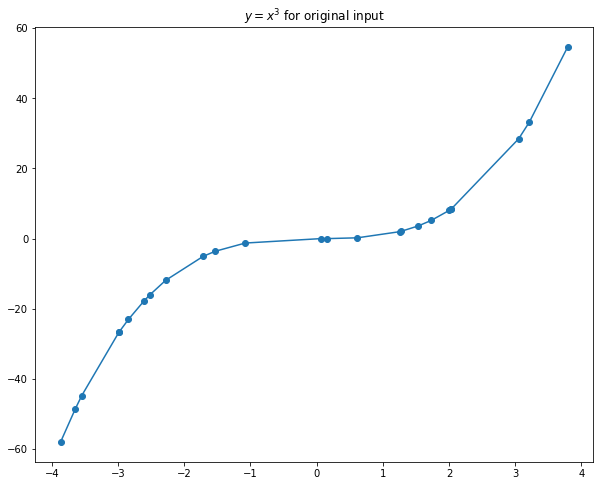

In [5]:
# Prepare the dataset
input_size = 25 # 25
train_size = (np.ceil(0.8 * input_size)).astype(np.int)
test_size = input_size - train_size
# Generate dataset

X = np.random.uniform(low=-4, high=4, size=input_size)
y = np.power(X,3) + np.random.normal(0, 3, size=input_size)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

y_original = np.power(X, 3)
X_sorted = X[X.argsort()]
y_orig_sorted = y_original[X.argsort()]

plt.rcParams['figure.figsize'] = (10,8)
plt.plot(X_sorted, y_orig_sorted, linestyle='-', marker='o')
plt.title('$y=x^3$ for original input')
plt.show()

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
X_real_test = np.linspace(-6, 6, 2000)
X_real_test = X_real_test.reshape(-1,1)

In [7]:
def batch_gen(x, y, batch_size):
    if (len(x) != len(y)):
        print("Error generating batches, source and target lists do not match")
        return
    total_samples = len(x)
    curr_batch_size = 0
    x_batch = []
    y_batch = []
    for i in range(len(x)):
        if (curr_batch_size < batch_size):
            x_batch.append(x[i])
            y_batch.append(y[i])
            curr_batch_size += 1
        else:
            yield(x_batch, y_batch)
            x_batch = [x[i]]
            y_batch = [y[i]]
            curr_batch_size = 1
    yield(x_batch, y_batch)

def batch_gen_random(x, y, batch_size):
    if (len(x) != len(y)):
        print("Error generating batches, source and target lists do not match")
        return
    total_samples = len(x)
    curr_batch_size = 0
    xy = list(zip(x,y))
    shuffle(xy)
    x_batch = []
    y_batch = []
    for i in range(len(xy)):
        if (curr_batch_size < batch_size):
            x_batch.append(xy[i][0])
            y_batch.append(xy[i][1])
            curr_batch_size += 1
        else:
            yield(x_batch, y_batch)
            x_batch = [xy[i][0]]
            y_batch = [xy[i][1]]
            curr_batch_size = 1
    yield(x_batch, y_batch)

In [8]:
def train(write_log=False):
    avg_error_train = []
    avg_error_valid = []
    batch_size = FLAGS.batch_size
    # Create a new model or reload existing checkpoint
    model = create_model(FLAGS)

    # Initiate TF session
    with tf.Session(graph=model.graph,config=tf.ConfigProto(allow_soft_placement=FLAGS.allow_soft_placement, 
                                          log_device_placement=FLAGS.log_device_placement,
                                          gpu_options=tf.GPUOptions(allow_growth=True))) as sess:
        restore_model(sess, model, FLAGS)
        total_batches = input_size // batch_size

        print("# Samples: {}".format(input_size))
        print("Total batches: {}".format(total_batches))

        # Split data to training and validation sets
        num_validation = test_size
        total_valid_batches = num_validation // batch_size
        total_train_batches = total_batches - total_valid_batches

        print("Total validation batches: {}".format(total_valid_batches))
        print("Total training batches: {}".format(total_train_batches)) 

        if (write_log):
            now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
            root_logdir = "tf_logs"
            logdir = "{}/run-{}/".format(root_logdir, now)
            # TensorBoard-compatible binary log string called a summary
            error_summary = tf.summary.scalar('Step-Loss', model.accuracy)
            # Write summaries to logfiles in the log directory
            file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

        step_time = 0.0
        start_time = time.time()
        global_start_time = start_time

        # Training loop
        print('Training..')
        for epoch in range(FLAGS.max_epochs):
            if (model.global_epoch_step.eval() >= FLAGS.max_epochs):
                print('Training is already complete.', \
                      'current epoch:{}, max epoch:{}'.format(model.global_epoch_step.eval(), FLAGS.max_epochs))
                break
            batches_gen = batch_gen_random(X_train, y_train, batch_size)
            batch_acc_train = []
            batch_acc_test = []
            for batch_i, batch in enumerate(batches_gen):
                X_batch = batch[0]
                Y_batch = batch[1]
                # Execute a single training step
                batch_acc_train = model.train(sess, X_batch, Y_batch)
                batch_acc_test = model.calc_accuracy(sess, X_test, y_test)
                if (write_log):
                    summary_str = error_summary.eval(feed_dict={model.inputs: X_batch, model.targets: Y_batch})
                    file_writer.add_summary(summary_str, model.global_step.eval())
                if (model.global_step.eval() % FLAGS.display_freq == 0):
                    time_elapsed = time.time() - start_time
                    step_time = time_elapsed / FLAGS.display_freq
                    print("Epoch: ", model.global_epoch_step.eval(),
                          "Batch: {}/{}".format(batch_i, total_train_batches),
                          "Train Mean Error:", batch_acc_train,
                          "Valid Mean Error:", batch_acc_test)
                # Save the model checkpoint
                if (model.global_step.eval() % FLAGS.save_freq == 0):
                    print('Saving the model..')
                    checkpoint_path = os.path.join(FLAGS.model_dir, FLAGS.model_name)
                    model.save(sess, checkpoint_path, global_step=model.global_step)
                    json.dump(model.config,
                              open('%s-%d.json' % (checkpoint_path, model.global_step.eval()), 'w'),
                              indent=2)
            # Increase the epoch index of the model
            model.global_epoch_step_op.eval()
            print('Epoch {0:} DONE'.format(model.global_epoch_step.eval()))
            avg_error_train.append(np.mean(batch_acc_train))
            avg_error_valid.append(np.mean(batch_acc_test))
        if (write_log):
            file_writer.close()
        print('Saving the last model..')
        checkpoint_path = os.path.join(FLAGS.model_dir, FLAGS.model_name)
        model.save(sess, checkpoint_path, global_step=model.global_step)
        json.dump(model.config,
                  open('%s-%d.json' % (checkpoint_path, model.global_step.eval()), 'w'),
                  indent=2)
        total_time = time.time() - global_start_time
        print('Training Terminated, Total time: {} seconds'.format(total_time))
        return avg_error_train, avg_error_valid

In [10]:
avg_error_train, avg_error_valid = train(write_log=write_log)

building model..
initializing placeholders...
building variables...
building layers...
configuring loss...
configuring optimization and gradients...
preparing evaluation...
preparing predictions
Created new model parameters..
# Samples: 25
Total batches: 5
Total validation batches: 1
Total training batches: 4
Training..
Epoch 1 DONE
Epoch 2 DONE
Epoch:  2 Batch: 1/4 Train Mean Error: 62.306335 Valid Mean Error: 196.12088
Epoch 3 DONE
Epoch 4 DONE
Epoch:  4 Batch: 3/4 Train Mean Error: 133.70824 Valid Mean Error: 459.76196
Epoch 5 DONE
Epoch 6 DONE
Epoch 7 DONE
Epoch:  7 Batch: 1/4 Train Mean Error: 124.46251 Valid Mean Error: 534.9875
Epoch 8 DONE
Epoch 9 DONE
Epoch:  9 Batch: 3/4 Train Mean Error: 177.72823 Valid Mean Error: 143.3518
Epoch 10 DONE
Epoch 11 DONE
Epoch 12 DONE
Epoch:  12 Batch: 1/4 Train Mean Error: 88.45249 Valid Mean Error: 143.5778
Epoch 13 DONE
Epoch 14 DONE
Epoch:  14 Batch: 3/4 Train Mean Error: 93.13218 Valid Mean Error: 178.07283
Epoch 15 DONE
Epoch 16 DONE
Epoc

Epoch 171 DONE
Epoch 172 DONE
Epoch:  172 Batch: 1/4 Train Mean Error: 8.200979 Valid Mean Error: 52.53235
Epoch 173 DONE
Epoch 174 DONE
Epoch:  174 Batch: 3/4 Train Mean Error: 11.951593 Valid Mean Error: 35.9862
Epoch 175 DONE
Epoch 176 DONE
Epoch 177 DONE
Epoch:  177 Batch: 1/4 Train Mean Error: 3.2046306 Valid Mean Error: 31.151236
Epoch 178 DONE
Epoch 179 DONE
Epoch:  179 Batch: 3/4 Train Mean Error: 12.001947 Valid Mean Error: 28.81187
Epoch 180 DONE
Epoch 181 DONE
Epoch 182 DONE
Epoch:  182 Batch: 1/4 Train Mean Error: 2.7896676 Valid Mean Error: 33.74388
Epoch 183 DONE
Epoch 184 DONE
Epoch:  184 Batch: 3/4 Train Mean Error: 5.8842535 Valid Mean Error: 50.68918
Epoch 185 DONE
Epoch 186 DONE
Epoch 187 DONE
Epoch:  187 Batch: 1/4 Train Mean Error: 17.638672 Valid Mean Error: 42.895386
Epoch 188 DONE
Epoch 189 DONE
Epoch:  189 Batch: 3/4 Train Mean Error: 9.143595 Valid Mean Error: 116.95776
Epoch 190 DONE
Epoch 191 DONE
Epoch 192 DONE
Epoch:  192 Batch: 1/4 Train Mean Error: 5.103

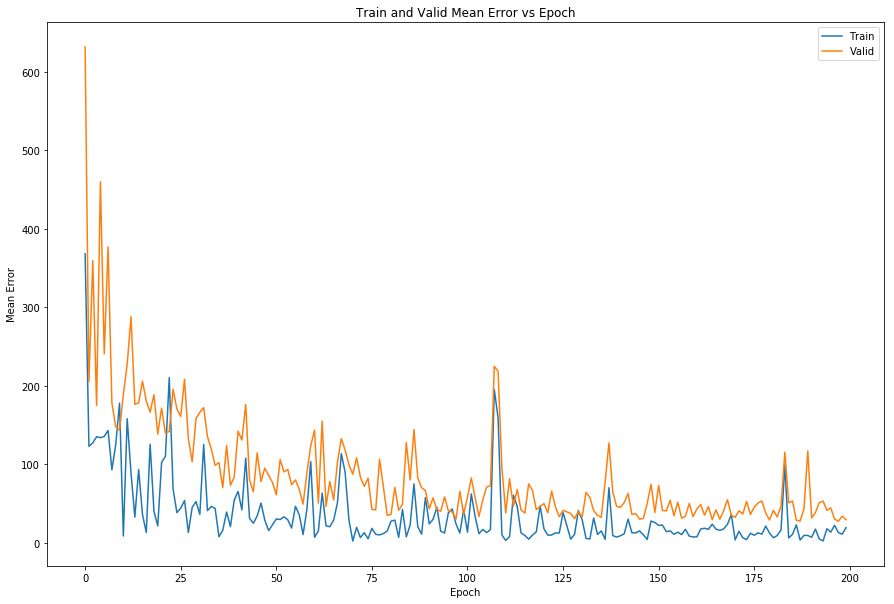

In [11]:
# Visualize:
plt.rcParams['figure.figsize'] = (15,10)
# MSE
plt.plot(range(FLAGS.max_epochs), avg_error_train, label="Train")
plt.plot(range(FLAGS.max_epochs), avg_error_valid, label="Valid")
plt.xlabel('Epoch')
plt.ylabel('Mean Error')
plt.title('Train and Valid Mean Error vs Epoch')
plt.legend()
plt.show()

# Predicting

In [12]:
def set_predict_flags(checkpoint=-1):
    tf.app.flags.FLAGS.__flags.clear()

    if (checkpoint == -1):
        ckpt = latest_ckpt
    else:
        ckpt = './model/linear_reg_bgd.ckpt-' + str(checkpoint)
    tf.app.flags.DEFINE_string('model_path',ckpt, 'Path to a specific model checkpoint.')

    # Runtime parameters
    tf.app.flags.DEFINE_boolean('allow_soft_placement', True, 'Allow device soft placement')
    tf.app.flags.DEFINE_boolean('log_device_placement', False, 'Log placement of ops on devices')

    # Ignore Cmmand Line
    tf.app.flags.DEFINE_string('x', '', '')
    tf.app.flags.DEFINE_string('d', '', '')
    tf.app.flags.DEFINE_string('p', '', '')
    tf.app.flags.DEFINE_string('o', '', '')
    tf.app.flags.DEFINE_string('w', '', '')
    tf.app.flags.DEFINE_string('a', '', '')
    tf.app.flags.DEFINE_string('b', '', '')
    tf.app.flags.DEFINE_string('j', '', '')
    tf.app.flags.DEFINE_string('u', '', '')

In [13]:
latest_ckpt = tf.train.latest_checkpoint('./model/')
set_predict_flags()
FLAGS = tf.app.flags.FLAGS

In [14]:
def load_config(FLAGS):
    
    config = json.load(open('%s.json' % FLAGS.model_path, 'r'))
    for key, value in FLAGS.__flags.items():
        config[key] = value.value

    return config

def load_model(config):
    
    model = BgdModel(config, 'predict')
    return model

def restore_model_predict(session, model):
    if tf.train.checkpoint_exists(FLAGS.model_path):
        print('Reloading model parameters..')
        model.restore(session, FLAGS.model_path)
    else:
        raise ValueError('No such file:[{}]'.format(FLAGS.model_path))

In [15]:
def predict(inputs):
    # Load model config
    config = load_config(FLAGS)
    # Load configured model
    model = load_model(config)
    with tf.Session(graph=model.graph,config=tf.ConfigProto(allow_soft_placement=FLAGS.allow_soft_placement, 
                                          log_device_placement=FLAGS.log_device_placement,
                                          gpu_options=tf.GPUOptions(allow_growth=True))) as sess:
        # Reload existing checkpoint
        restore_model_predict(sess, model)
        
        print("Predicting results for inputs...")
        # Prepare results dict
        results = {}
        # Predict
        results['predictions'] = model.predict(sess, inputs)
        # Statistics
        results['max_out'] = model.max_output.eval(feed_dict={model.inputs: inputs})
        results['min_out'] = model.min_output.eval(feed_dict={model.inputs: inputs})
        upper_confidence, lower_confidence = model.calc_confidence(sess, inputs)
        results['upper_confidence'] = upper_confidence
        results['lower_confidence'] = lower_confidence
        results['avg_sigma'] = np.mean([s.eval() for s in model.sigma_s])
        print("Finished predicting.")
    return results

In [16]:
# y_train_res = predict(X_train)
# y_test_res = predict(X_test)
y_real_test_res = predict(X_real_test)

building model..
initializing placeholders...
building variables...
building layers...
configuring loss...
configuring optimization and gradients...
preparing evaluation...
preparing predictions
Reloading model parameters..
INFO:tensorflow:Restoring parameters from ./model/linear_reg_bgd.ckpt-800
model restored from ./model/linear_reg_bgd.ckpt-800
Predicting results for inputs...
Finished predicting.


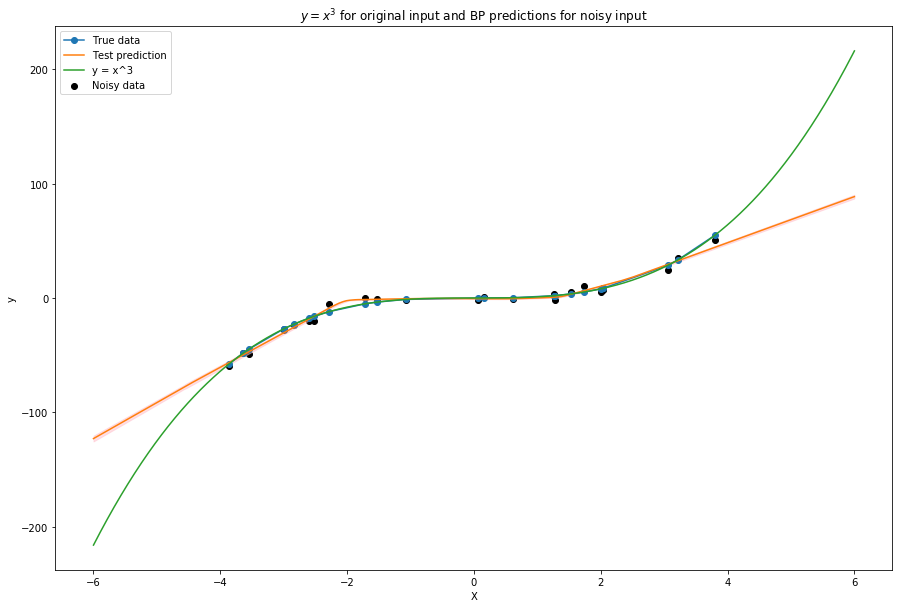

In [17]:
# Predictions of train and test vs original
X_train_sorted = X_train[X_train.T.argsort()]
# X_test_sorted = X_test[X_test.argsort()]

# y_train_pred_sorted = y_train_res['predictions'][X_train.T.argsort()]
# y_test_pred_sorted = y_test_pred[X_test.argsort()]

y_noisy_sorted = y[X.argsort()]
y_real = np.power(X_real_test, 3)

plt.scatter(X_sorted, y_noisy_sorted, label='Noisy data', c='k')
plt.plot(X_sorted, y_orig_sorted, linestyle='-', marker='o', label='True data')
plt.plot(X_real_test, y_real_test_res['predictions'], linestyle='-', label= 'Test prediction')
plt.plot(X_real_test, y_real, linestyle='-', label= 'y = x^3')
# plt.fill_between(X_real_test[:,0], y_real_test_res['max_out'][:,0] ,
#                  y_real_test_res['min_out'][:,0], interpolate=True, color='pink', alpha=0.5)
low_conf = y_real_test_res['predictions'][:,0] + 30 * y_real_test_res['lower_confidence'][:,0]
up_conf = y_real_test_res['predictions'][:,0] + 30 * y_real_test_res['upper_confidence'][:,0]
plt.fill_between(X_real_test[:,0], low_conf, up_conf, interpolate=True, color='pink', alpha=0.5)
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title(('$y=x^3$ for original input and BP predictions for noisy input'))
plt.show()

In [ ]:
y_real_test_res['predictions'][:,0]